In [2]:
import cv2
import skimage.io as io
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import helper as helper
from dataset import *


In [3]:
label_path='../labels/coco/labels/val2017/000000007108.txt'
with open(label_path) as box:
    box=box.read()
    box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])

b= box.values.astype(np.float32)
bboxes=b
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T

img_path='../images/val2017/000000007108.jpg'
img=cv2.imread(img_path)[:,:,::-1] 

sample={'images': img,
        'boxes': boxes}

(h,w,c)=img.shape

bboxes[:,1]=bboxes[:,1]*w
bboxes[:,2]=bboxes[:,2]*h
bboxes[:,3]=bboxes[:,3]*w
bboxes[:,4]=bboxes[:,4]*h
bboxes[:,1]=bboxes[:,1]-bboxes[:,3]/2
bboxes[:,2]=bboxes[:,2]-bboxes[:,4]/2
bboxes[:,3]=bboxes[:,1]+bboxes[:,3]
bboxes[:,4]=bboxes[:,2]+bboxes[:,4]
print(bboxes)


[[ 20.        125.69025    26.39006   418.32      420.7199   ]
 [ 20.        401.19006    77.46982   632.98975   426.       ]
 [ 20.        338.12994     0.9099388 504.32       93.55983  ]
 [ 20.        120.88031   219.        203.62015   345.95013  ]
 [ 20.        567.63007    49.78981   637.34015   372.88995  ]]


In [88]:
import imgaug as ia
from imgaug import parameters as iap
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


image = sample['images']

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=b[1], y1=b[2], x2=b[3], y2=b[4], label=b[0]) for b in bboxes], shape=image.shape)

seq = iaa.Sequential([
    iaa.LinearContrast(alpha=(0.1, 1.9)),
    iaa.ShearX((-30, 30)),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Grayscale(alpha=(0.1, 0.9)),
    iaa.Sometimes(
        0.5,
        iaa.HistogramEqualization(),
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Solarize(0.5, threshold=(0, 256)),
    # Strengthen or weaken the contrast in each image.
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_px={"x": (-150, 150)},
        rotate=(-30, 30)
    )
], random_order=True)

# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
# image_before = bbs.draw_on_image(image, size=2)
# image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

BB 0: (125.6902, 26.3901, 418.3200, 420.7199) -> (57.1559, 25.3875, 540.9116, 430.3478)
BB 1: (401.1901, 77.4698, 632.9897, 426.0000) -> (333.8722, 52.5120, 734.7347, 407.7458)
BB 2: (338.1299, 0.9099, 504.3200, 93.5598) -> (395.8788, -7.5085, 606.4836, 97.4114)
BB 3: (120.8803, 219.0000, 203.6201, 345.9501) -> (99.7300, 230.3876, 244.0585, 359.6098)
BB 4: (567.6301, 49.7898, 637.3401, 372.8900) -> (517.9814, 25.7096, 745.1509, 340.4637)


[[ 57.15588    25.387451  540.91156   430.34778  ]
 [333.87216    52.51197   734.7347    407.7458   ]
 [395.87875    -7.5085473 606.4836     97.411354 ]
 [ 99.72996   230.38759   244.0585    359.60977  ]
 [517.9814     25.709621  745.1509    340.46365  ]]


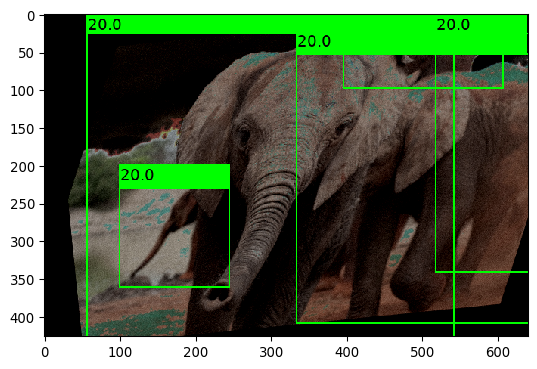

(5, 1)
(5, 4)
[[ 20.         57.15588    25.387451  540.91156   430.34778  ]
 [ 20.        333.87216    52.51197   734.7347    407.7458   ]
 [ 20.        395.87875    -7.5085473 606.4836     97.411354 ]
 [ 20.         99.72996   230.38759   244.0585    359.60977  ]
 [ 20.        517.9814     25.709621  745.1509    340.46365  ]]


In [97]:
new_bboxes=bbs_aug.to_xyxy_array()
bbs_aug=bbs_aug.remove_out_of_image()

ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

labels=np.array([[box.label for box in bbs_aug.bounding_boxes]]).T
new_bboxes=bbs_aug.to_xyxy_array()
np.hstack((labels,new_bboxes))


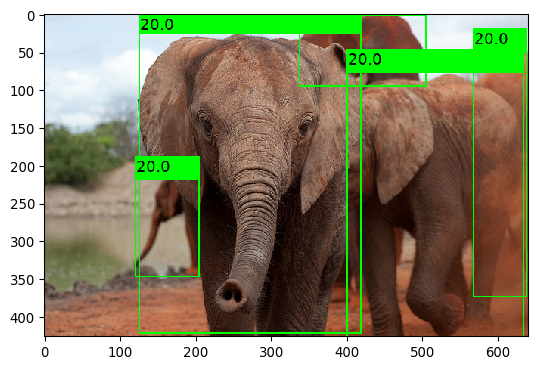

In [48]:
ia.imshow(bbs.draw_on_image(image, size=2))

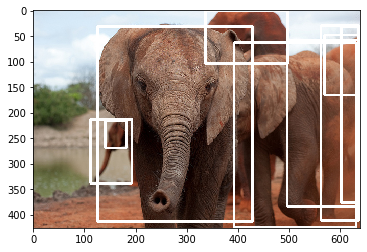

In [22]:
box=open("../detections/000000007108.txt")
box=box.read()
box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','conf','xc','yc','w','h'])
b= box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
objectness = b.T[1].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
# conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[2:],objectness.T,one_hot_target.T)).T

plt.imshow(draw_rect(sample['images'], boxes))
plt.savefig('elephants.png')

In [8]:
diff=1
import random
print(random.uniform(1,2))
def shear(sample):
    
    img=sample['images']
    bboxes=sample['boxes']
    shear_factor = 0.6

    w,h = img.shape[1], img.shape[0]
    
    if shear_factor < 0:
        sample = RandomHorizontalFlip(-1)(sample)
        img=sample['images']
        bboxes=sample['boxes']

    
    M = np.array([[1, abs(shear_factor), 0],[0,1,0]])

    nW =  img.shape[1] + abs(shear_factor*img.shape[0])

    bboxes[:,0] += bboxes[:,1]* abs(torch.tan(torch.tensor([shear_factor])))
    bboxes[:,2] += bboxes[:,3]* abs(torch.tan(torch.tensor([shear_factor])))
    


    img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))


#     if shear_factor < 0:
#         sample = RandomHorizontalFlip(-1)(sample)
#         img=sample['images']
#         bboxes=sample['boxes']
#         print(bboxes)
#     plt.imshow(draw_rect(img, bboxes))

    img = cv2.resize(img, (w,h))

    scale_factor_x = nW / w
    print(scale_factor_x)
    bboxes[:,:4] /= torch.tensor([scale_factor_x, 1, scale_factor_x, 1])
    print(bboxes)
    return img, bboxes

1.5159962084858698


1.8668171557562077
tensor([[0.4982, 0.5090, 0.7924, 0.9685, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.6095, 0.3022, 0.1087, 0.0952, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

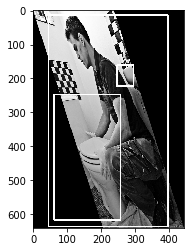

In [49]:
img, bboxes = shear(sample)

plt.imshow(draw_rect(img, bboxes))




In [14]:
import cv2 
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    h=im.shape[0]
    w=im.shape[1]
    cords[:,0]=cords[:,0]*w
    cords[:,1]=cords[:,1]*h
    cords[:,2]=cords[:,2]*w
    cords[:,3]=cords[:,3]*h
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0]-cord[2]/2, cord[1]-cord[3]/2) , (cord[0]+cord[2]/2, cord[1]+cord[3]/2)
        
#         pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

In [10]:

import matplotlib.pyplot as plt

translate=RandomTranslate()
flip=RandomVerticalFlip()

rotate = RandomRotate(20) 
sample=flip(sample)
sample=translate(sample)
sample = rotate(sample)

plt.imshow(draw_rect(img, bboxes))

TypeError: unsupported operand type(s) for &: 'float' and 'float'

In [11]:
img, bboxes = rotate(sample)

plt.imshow(draw_rect(img, bboxes))


torch.Size([16, 8])
torch.Size([64, 2])
torch.Size([2, 3])


RuntimeError: The size of tensor a (3) must match the size of tensor b (64) at non-singleton dimension 1

In [12]:
print(helper.get_corners(bboxes))

NameError: name 'bboxes' is not defined

In [ ]:
import torch

a=torch.tensor([[[1,2,2,4,0,0,0,1],[2,3,5,3,0,0,1,0]]])
print(a.shape)
b=((a[:,:,4:]==1).nonzero())
b=b[:,-1].unsqueeze(0).unsqueeze(-1)
print(b.shape)
new=a[:,:,:4]
print(new.shape)
new=torch.cat((new.T,b.T)).T
print(new)
sorted_pred=torch.sort(new[0,:,4],descending=False)
print(sorted_pred)

In [ ]:
b = box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T




In [ ]:
file_name='images/train2017.zip'
with ZipFile(file_name, 'r') as zip:
    image=zip.read('train2017/000000408542.jpg')
    img = cv2.imdecode(np.frombuffer(image, np.uint8),1)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    io.imshow(im_rgb)
    io.imsave('fig.png',im_rgb)

In [ ]:
df=pd.read_csv('pointers/train2017.txt',names=['filename'])

In [ ]:
df['box']=df['filename'].apply(lambda x: 'coco/labels/'+x.split('.')[0]+'.txt')

In [ ]:
df['box']

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim

import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')


# idf_weights=pd.read_csv('../idf.csv')


hyperparameters={'lr':0.0001,
                 'batch_size':16,
                 'weight_decay':0.001,
                 'momentum':0.9,
                 'optimizer':'sgd',
                 'alpha':0.5,
                 'gamma':0,
                 'lcoord':5,
                 'lno_obj':1,
                 'iou_type':(0,0,0),#(GIoU,DIoU,CIoU) default is 0,0,0 for iou
                 'iou_ignore_thresh':0.5,
                 'tfidf':True,
                 'idf_weights':True,
                 'workers':4,
                 'path':'augment',
                 'reduction':'sum'}


if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        

'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        

transformed_dataset=Coco(partition='train',
                                           transform=transforms.Compose([
                                            Augment(),
                                            ResizeToTensor(inp_dim)
                                           ]))


writer = SummaryWriter('../results/'+hyperparameters['path'])
dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

lambda1 = lambda epoch: 0.95**epoch
scheduler=optim.lr_scheduler.LambdaLR(optimizer, lambda1, last_epoch=-1)

epochs=50
total_loss=0
write=0
misses=0
avg_iou=0
for e in range(epochs):
    prg_counter=0
    train_counter=0
    total_loss=0
    avg_iou=0
    avg_infs=0
    avg_conf=0
    avg_no_conf=0
    avg_pos=0
    avg_neg=0
    print("\n epoch "+str(e))
    misses=0
    for images,targets,img_names in dataloader:
        optimizer.zero_grad()
        targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
        images=images.cuda()
        raw_pred = model(images, torch.cuda.is_available())
        raw_pred=helper.expand_predictions(raw_pred,mask)
        true_pred=util.transform(raw_pred.clone(),anchors,offset,strd)
        targets=targets.unsqueeze(-3)
        targets=targets.cuda()
        iou_mask,noobj_mask=util.get_responsible_masks(true_pred,targets,offset,strd,mask,inp_dim,hyperparameters)
        
        iou1=torch.diag(util.bbox_iou(util.get_abs_coord(true_pred[iou_mask.T,:].unsqueeze(-3)),util.transpose_target(get_abs_coord(targets)*inp_dim),hyperparameters['iou_type']))
        iou=iou1.mean().item()
        noobj_box=raw_pred[:,:,4:5].clone()
        noobj_box=helper.uncollapse(noobj_box,mask)
        noobj_mask=helper.uncollapse(noobj_mask.T.unsqueeze(-1),mask)
        
        
        conf=raw_pred[iou_mask.T,:][:,4:5].mean().item()
        class_mask=targets[:,:,5:].type(torch.BoolTensor).squeeze(0)
        if(iou_mask.sum()==class_mask.shape[0]):
            pos_class=raw_pred[iou_mask.T,:][:,5:][class_mask].mean().item()
            neg_class=raw_pred[iou_mask.T,:][:,5:][~class_mask].mean().item()
        else:
            pos_class=0
            neg_class=0
            
        noobj_box=noobj_box[noobj_mask]
        no_obj_conf=noobj_box.mean().item()
        
        raw_pred=raw_pred[iou_mask.T,:]
        anchors=anchors[iou_mask.T,:]
        offset=offset[iou_mask.T,:]
        strd=strd[iou_mask.T,:]
        
        if(strd.shape[0]==sum(mask)):#this means that iou_mask failed and was all true, because max of zeros is true for all lenght of mask strd
            targets[:,:,0:4]=targets[:,:,0:4]*inp_dim
            targets=targets.squeeze(0)
            targets[:,0:4]=util.transform_groundtruth(targets,anchors,offset,strd)
            with torch.autograd.set_detect_anomaly(True):
                loss=util.yolo_loss(raw_pred,targets,noobj_box,mask,hyperparameters)
                loss.backward()
                optimizer.step()
            
            avg_conf=avg_conf+conf
            avg_no_conf=avg_no_conf+no_obj_conf
            avg_pos=avg_pos+pos_class
            avg_neg=avg_neg+neg_class
            total_loss=total_loss+loss.item()
            avg_iou=avg_iou+iou
            sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
            sys.stdout.write(' IoU:' +str(iou)+' pob:'+str(conf)+ ' nob:'+str(no_obj_conf))
            sys.stdout.write(' PCls:' +str(pos_class)+' ncls:'+str(neg_class))
            sys.stdout.flush()
            prg_counter=prg_counter+1
            train_counter=train_counter+1
        else:
            print('missed')
            print(strd.shape[0])
            prg_counter=prg_counter+1
        iou1=iou1.tolist()
        iou_per_class= [0] * 80
        averager_per_class=[1] * 80
        for i,el in enumerate(iou1):
            name=targets[i,5:].max(0)[1].cpu().detach().numpy()
            iou_per_class[name]=iou_per_class[name]+el
            averager_per_class[name]=averager_per_class[name]+1
        for i in range(80):
            if (iou_per_class[i]!=0):
                if i<40:
                    writer.add_scalar('Iou0/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
                else:
                    writer.add_scalar('Iou1/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
        writer.add_scalar('AvLoss/train', total_loss/train_counter, train_counter)

        
        writer.add_scalar('AvIoU/train', avg_iou/train_counter, train_counter)

        writer.add_scalar('AvPConf/train', avg_conf/train_counter, train_counter)
        
        writer.add_scalar('AvNConf/train', avg_no_conf/train_counter, train_counter)
        
        writer.add_scalar('AvClass/train', avg_pos/train_counter, train_counter)
        
        writer.add_scalar('AvNClass/train', avg_neg/train_counter, train_counter)
        
        del loss, raw_pred, targets, true_pred, images,iou,noobj_box,conf,iou1
        torch.cuda.empty_cache()
    if misses>0:
        break
#     torch.save(model.state_dict(), PATH)
#     writer.add_scalar('Loss/train', total_loss/train_counter, e)
#     writer.add_scalar('AIoU/train', avg_iou/train_counter, e)
#     writer.add_scalar('PConf/train', avg_conf/train_counter, e)
#     writer.add_scalar('NConf/train', avg_no_conf/train_counter, e)
#     writer.add_scalar('PClass/train', avg_pos/train_counter, e)
#     writer.add_scalar('NClass/train', avg_neg/train_counter, e)
    print('\ntotal number of misses is ' + str(misses))
    print('\n total average loss is '+str(total_loss/train_counter))
    print('\n total average iou is '+str(avg_iou/train_counter))

cuda:0
Using  2 GPUs!
Length of dataset is 118287


 epoch 0


/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Pgr:0.0% L:3.904004607865652 IoU:0.6927249431610107 pob:0.2178376168012619 nob:0.0008399877115152776 PCls:0.7242233157157898 ncls:0.003490843577310443

KeyboardInterrupt: 

In [2]:
torch.save(model.state_dict(), PATH)

In [6]:
import torch
a=torch.tensor([0.93,0.35])
print(torch.softmax(a,dim=0))

tensor([0.6411, 0.3589])


In [9]:
test=torch.tensor([[[1,2],[3,4]]])
print(test.shape[1:])

torch.Size([2, 2])


In [2]:
print(mask)

idf=torch.stack([targets[:i,5:].sum(axis=0) for i in mask],dim=0)
idf[idf>1]=1

print(idf.sum(axis=0))

[14, 3, 14, 28, 11, 2, 8, 2, 3, 2, 17, 1, 12, 2, 4, 1]
tensor([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


In [4]:

tf=torch.tensor([1/mask[i] for i in range(len(mask)) for j in range(mask[i])]).cuda()
obj_idf=hyperparameters['idf_weights']
print(obj_idf)
classes=targets[:,5:].max(1)[1]
print(classes.tolist())
print(obj_idf['obj_idf'][classes.tolist()])
idf=np.array(obj_idf['obj_idf'][classes.tolist()])
idf=torch.tensor(idf,device='cuda')
idf=-torch.log(idf)

tfidf=tf*idf
tfidf=torch.softmax(tfidf,dim=0)

    index   obj_idf   img_idf
0       0  0.302670  0.186926
1       1  0.008302  0.010735
2       2  0.051216  0.037242
3       3  0.010182  0.012612
4       4  0.006035  0.006895
..    ...       ...       ...
75     75  0.007738  0.010365
76     76  0.001722  0.002799
77     77  0.005564  0.006248
78     78  0.000233  0.000551
79     79  0.002288  0.004440

[80 rows x 3 columns]
[22, 22, 22, 22, 59, 62, 65, 75, 75, 0, 36, 56, 56, 56, 56, 56, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 39, 41, 41, 41, 41, 41, 41, 56, 56, 56, 60, 0, 0, 56, 56, 60, 60, 60, 0, 0, 2, 26, 26, 26, 41, 56, 56, 60, 60, 26, 45, 14, 49, 60, 58, 75, 75, 75, 56, 25, 0, 0, 0, 0, 0, 0, 0, 8, 25, 0, 0, 0, 0, 5, 25, 25, 25, 25, 25, 25, 25, 25, 24, 26, 0, 0, 0, 0, 0, 0, 25, 25, 25, 26, 26, 26, 26, 26, 26, 25, 26, 0, 62, 56, 56, 74, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 44, 50, 48, 48, 0, 30, 49, 68, 39, 57, 56, 0, 73, 73, 73, 73, 15, 43, 45, 60, 0, 47, 47, 47, 47, 46, 46, 46, 0, 0, 0, 0, 0, 0, 0, 8, 14, 26, 26, 26, 45, 

In [ ]:
targets2,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
transformed_output=true_pred
targets=targets
offset=offset
strd=strd
mask=mask
inp_dim
'''
this function takes the transformed_output and
the target box in respect to the resized image size
and returns a mask which can be applied to select the 
best raw input,anchors and cx_cy_offset
and the noobj_mask for the negatives
targets is a list
'''
#first transpose the centered normalised target coords
centered_target=transpose_target(targets)[:,:,0:2]
#multiply by inp_dim then devide by stride to get the relative grid size coordinates, floor the result to get the corresponding cell
centered_target=torch.floor(centered_target*inp_dim/strd)
#create a mask to find where the gt falls into which gridcell in the grid coordinate system
fall_into_mask=centered_target==offset
fall_into_mask=fall_into_mask[:,:,0]&fall_into_mask[:,:,1]
#     fall_into_mask= ~fall_into_mask
#create a copy of the transformed output
best_bboxes=transformed_output.clone()
#apply reverse mask to copy in order to zero all other bbox locations
best_bboxes[~fall_into_mask]=0   
#transform the copy to xmin,xmax,ymin,ymax
best_responsible_coord=get_abs_coord(best_bboxes)
targets=transpose_target(get_abs_coord(targets))*inp_dim
#calculate best iou and mask
responsible_iou=bbox_iou(best_responsible_coord,targets,True)

responsible_iou[responsible_iou.ne(responsible_iou)] = 0
responsible_mask=responsible_iou.max(dim=0)[0] == responsible_iou

print(responsible_mask.shape)

abs_coord=get_abs_coord(transformed_output)
iou=bbox_iou(abs_coord,targets,True)
iou[iou.ne(iou)] = 0
ignore_mask=0.5<=iou
inverted_mask=iou.max(dim=0)[0] != iou
noobj_mask=~same_picture_mask(responsible_mask.clone()|ignore_mask,mask)

In [ ]:
print(responsible_mask)
if(responsible_mask.sum()>sum(mask)):
    print('jello')
    responsible_mask1=correct_iou_mask(responsible_mask,fall_into_mask)
print(responsible_mask1.shape)

In [ ]:
a=torch.randint(0, 9, (1,)) == torch.arange(9)
a=a.repeat(5)
a=a.repeat(2,1)
print(a)
print(a.T)

In [15]:
hyperparameters={'lr':0.01,'batch_size':16,'weight_decay':0.001,'optimizer':'sgd','alpha':0.5,'gamma':2,'iou_ignore_thresh':0.5,'tfidf':True,'reduction':'sum'}

In [ ]:
le_mask=(responsible_mask.sum(axis=0)==responsible_mask.sum(axis=0).max())

In [ ]:
responsible_mask[:,le_mask]=(responsible_mask[:,le_mask]&fall_into_mask[le_mask,:].T)

In [ ]:
print(le_mask)
print(fall_into_mask[le_mask,:].shape)


In [ ]:
a=torch.tensor([1,2,3,4,5,6,6,6])
indices=(((a==a.max())==True).nonzero())
for ind in indices:
    print(ind)

In [1]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes


net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph
cx_cy=net.cx_cy
stride=net.stride

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/augment.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if torch.cuda.device_count() > 1:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()




print('testing with '+ PATH +'\n')
transformed_dataset=Coco(partition='val',
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=16

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=4)

true_pos=0
false_pos=0
counter=0
iou_threshold=0.5
confidence=0.01
recall_counter=0
max_detections=None
prg_counter=0
for images,targets,img_name in dataloader:
    inp=images.cuda()
    raw_pred = model(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)
    
    classes=true_pred[:,:,5:].max(2)[0]
    objectness=true_pred[:,:,4]
    
    sorted_pred=torch.sort(objectness*classes,descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]
    
    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]
    
    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]
#     pred_final[:,0:4]=pred_final[:,0:4]/inp_dim
    helper.write_pred(img_name,pred_final,inp_dim,max_detections)
    
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%')
    prg_counter=prg_counter+1
    
    

print("--- %s seconds ---" % (time.time() - start_time))

# Read txt files containing bounding boxes (ground truth and detections)


cuda:0
Using  2 GPUs!
testing with ../pth/augment.pth

Length of dataset is 5000



/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Pgr:99.83999999999999%--- 204.3950960636139 seconds ---


In [ ]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
boundingboxes = helper.getBoundingBoxes()


In [2]:
from Evaluator import *
from utils import *
from BoundingBox import BoundingBox

from BoundingBoxes import BoundingBoxes


boundingboxes = helper.getBoundingBoxes()
evaluator = Evaluator()

iou=0.5
MMap=0
while iou<1:
    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=iou)
#     print("Average precision values per class:\n")
    # Loop through classes to obtain their metrics
    mAP=0
    counter=0
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        # Print AP per class
        mAP=average_precision+mAP
#         print('%s: %f' % (c, average_precision))
    MMap=MMap+mAP/80
    iou=iou+0.05
    print('\nCOCO map is:',MMap)


COCO map is: 0.5622569082794988

COCO map is: 1.0621334901314776


KeyboardInterrupt: 

In [11]:
0.6403413112473646
0.6503946905414258
for mc in metricsPerClass:
    c = mc['class']
    average_precision = mc['AP']
    print('%s: %f' % (c, average_precision))

0: 0.002488
1: 0.004891
10: 0.018336
11: 0.005930
12: 0.000000
13: 0.003791
14: 0.000481
15: 0.006630
16: 0.006595
17: 0.002570
18: 0.001255
19: 0.004700
2: 0.001581
20: 0.004387
21: 0.035628
22: 0.003999
23: 0.002304
24: 0.000000
25: 0.002457
26: 0.000007
27: 0.000331
28: 0.002861
29: 0.001265
3: 0.000095
30: 0.000228
31: 0.000000
32: 0.000383
33: 0.004960
34: 0.000265
35: 0.000054
36: 0.000025
37: 0.000104
38: 0.000282
39: 0.000466
4: 0.001977
40: 0.000434
41: 0.000983
42: 0.000000
43: 0.000000
44: 0.000072
45: 0.001270
46: 0.000600
47: 0.001220
48: 0.001997
49: 0.003919
5: 0.007391
50: 0.000012
51: 0.000000
52: 0.001000
53: 0.010517
54: 0.001178
55: 0.001211
56: 0.000385
57: 0.012364
58: 0.001321
59: 0.007608
6: 0.009306
60: 0.006472
61: 0.002968
62: 0.003310
63: 0.002830
64: 0.002123
65: 0.000267
66: 0.000934
67: 0.005071
68: 0.000000
69: 0.000748
7: 0.003656
70: 0.007937
71: 0.003431
72: 0.002753
73: 0.000185
74: 0.000374
75: 0.000699
76: 0.002137
77: 0.000354
78: 0.000000
79: 0.0

In [6]:
print(MMap/10)

0.3651112345706164


In [7]:
print('%s: %f' % (c, average_precision))

9: 0.000231


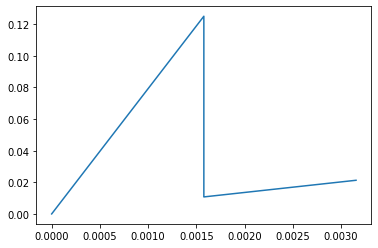

In [4]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)

In [ ]:
from Evaluator import *
evaluator = Evaluator()
metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
mAP=0
counter=0
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    mAP=average_precision+mAP
    print('%s: %f' % (c, average_precision))

print('map is:',mAP/80)

In [ ]:
0.07290217209136615

In [ ]:
import pandas as pd
coord=pred_final[:,:4].cpu().detach().numpy()
conf=pred_final[:,4:5].cpu().detach().numpy()
mat=np.hstack((conf,coord))

classes=pred_final[:,5:].max(1)[1].cpu().detach().numpy()
classes=np.array([classes]).T

mat=np.hstack((classes,mat))
mat=np.array(mat)

df=pd.DataFrame(mat,index=None,columns=None)
df[0]=df[0].apply(lambda x: int(x))

df.to_csv('test.txt',sep=' ',header=False,index=None)

In [ ]:
np.savetxt('test.txt',mat)

In [ ]:
a=torch.tensor([1,2,2,3,4,2,3,1,4])
print(a.max(0))

In [ ]:
import skimage.io as io

In [ ]:
image=(inp).squeeze(0)
image=np.array(image.cpu())
print(image.shape)
image =  image[:,:,::-1].transpose((1,2,0))
print(image.shape)

In [ ]:
import pandas as pd
import glob

all_files = glob.glob('plots/' + "/*.csv")

li = []

for filename in sorted(all_files):
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)


In [10]:
df=pd.read_csv('../pointer.csv')
print(df)

        Unnamed: 0                         img  \
0                0  train2017/000000109622.jpg   
1                1  train2017/000000160694.jpg   
2                2  train2017/000000308590.jpg   
3                3  train2017/000000327573.jpg   
4                4  train2017/000000062929.jpg   
...            ...                         ...   
118281      118282  train2017/000000421432.jpg   
118282      118283  train2017/000000299290.jpg   
118283      118284  train2017/000000119428.jpg   
118284      118285  train2017/000000148101.jpg   
118285      118286  train2017/000000337779.jpg   

                                           box  
0       coco/labels/train2017/000000109622.txt  
1       coco/labels/train2017/000000160694.txt  
2       coco/labels/train2017/000000308590.txt  
3       coco/labels/train2017/000000327573.txt  
4       coco/labels/train2017/000000062929.txt  
...                                        ...  
118281  coco/labels/train2017/000000421432.txt  
118282 

In [11]:
df=df[:None]
print(df)

        Unnamed: 0                         img  \
0                0  train2017/000000109622.jpg   
1                1  train2017/000000160694.jpg   
2                2  train2017/000000308590.jpg   
3                3  train2017/000000327573.jpg   
4                4  train2017/000000062929.jpg   
...            ...                         ...   
118281      118282  train2017/000000421432.jpg   
118282      118283  train2017/000000299290.jpg   
118283      118284  train2017/000000119428.jpg   
118284      118285  train2017/000000148101.jpg   
118285      118286  train2017/000000337779.jpg   

                                           box  
0       coco/labels/train2017/000000109622.txt  
1       coco/labels/train2017/000000160694.txt  
2       coco/labels/train2017/000000308590.txt  
3       coco/labels/train2017/000000327573.txt  
4       coco/labels/train2017/000000062929.txt  
...                                        ...  
118281  coco/labels/train2017/000000421432.txt  
118282 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'

title_list=['AIoU_train','Loss_train','NClass_train','NConf_train','PClass','PConf']

fig = plt.figure(figsize=(30, 10))
fig.suptitle('KL for xy loss')
fig.subplots_adjust(hspace=0.3, wspace=-.6)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
i=2
k=0
while i <18:
    ax = fig.add_subplot(2, 9, i)
    frame.plot(x =1 , y = i,ax=ax,legend=False)
    ax.set_title(title_list[k])
    i=i+3
    k=k+1
plt.savefig('original.png')
plt.show()

In [8]:
import os
import pandas as pd
import glob
import sys


df = pd.DataFrame(columns=['class','xc','yc','w','h','filename'])
current_dir='/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/yolo'
os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/val2017')
print(os.getcwd())
files = glob.glob("*.txt")
dataset_len=len(files)
prg_counter=0
print(dataset_len)
for file in files:
    with open(file) as f:
        f=f.read()
        box=pd.DataFrame([map(float,x.split()) for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[file for x in f.rstrip('\n').split('\n')]
        df = df.append(box, ignore_index = True)
        
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100)+'%')
    prg_counter+=1

print(df)
obj_idf=(df['class'].value_counts(normalize=True).reset_index(name='obj_idf'))
new_df=df.groupby('filename')['class'].value_counts().reset_index(name='count')
img_idf=new_df['class'].value_counts(normalize=True).reset_index(name='img_idf')

obj_idf['img_idf']=img_idf['img_idf']


/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/val2017
4952
Pgr:99.97980613893377%       class        xc        yc         w         h          filename
0       39.0  0.125266  0.228448  0.211750  0.450437  000000312192.txt
1       60.0  0.503383  0.590854  0.993234  0.783292  000000312192.txt
2        0.0  0.732789  0.245490  0.534422  0.442437  000000312192.txt
3       40.0  0.069102  0.310854  0.138203  0.532583  000000312192.txt
4       40.0  0.322680  0.081260  0.074203  0.150479  000000312192.txt
...      ...       ...       ...       ...       ...               ...
36330   73.0  0.464984  0.428341  0.018969  0.233785  000000571893.txt
36331   73.0  0.490781  0.439930  0.045188  0.219673  000000571893.txt
36332   73.0  0.585711  0.461519  0.040328  0.178131  000000571893.txt
36333   74.0  0.012438  0.348014  0.024875  0.036215  000000571893.txt
36334   73.0  0.474445  0.770257  0.018891  0.208879  000000571893.txt

[36335 rows x 6 columns]


In [26]:
df['area']=df['w']*df['h']
total_area=df['area'].sum()

area_idf=df.groupby('class')['area'].sum().reset_index(name='area')
print(area_idf)

    class        area
0     0.0  827.767526
1     1.0   17.211961
2     2.0   47.870532
3     3.0   51.120808
4     4.0   25.351540
..    ...         ...
75   75.0   11.731437
76   76.0    7.503084
77   77.0   32.849607
78   78.0    0.586456
79   79.0    1.478670

[80 rows x 2 columns]


In [24]:
print(obj_idf)

    index   obj_idf   img_idf
0     0.0  0.296601  0.184061
1     2.0  0.052787  0.039642
2    56.0  0.048741  0.036566
3    73.0  0.031072  0.034242
4    39.0  0.027879  0.026656
..    ...       ...       ...
75   79.0  0.001569  0.002529
76   68.0  0.001514  0.002324
77   76.0  0.000991  0.001914
78   78.0  0.000303  0.000615
79   70.0  0.000248  0.000547

[80 rows x 3 columns]


In [39]:
import os
import pandas as pd
import glob
import sys


from multiprocessing import Pool # for reading the CSVs faster

def my_read_csv(filename):
    try:
        f=open(filename).read()
        box=pd.DataFrame([map(float,x.split()) for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[filename for x in f.rstrip('\n').split('\n')]
        return box
    except FileNotFoundError:
        return None

def load_csvs():
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """
    # set up your pool
    pool = Pool() 
    os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/train2017')
    print(os.getcwd())
    files = os.listdir('.')
    file_list = [filename for filename in files if filename.split('.')[1]=='txt']
    print(len(file_list))
    df_list = pool.map(my_read_csv, file_list)
    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [40]:
df=load_csvs()

/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/train2017
117266


In [42]:
df1=df

In [46]:
print(df)
df['area']=df['w']*df['h']
total_area=df['area'].sum()

area_idf=df.groupby('class')['area'].sum().reset_index(name='area')
print(area_idf['area']/total_area)

        class        xc        yc         w         h          filename  \
0        30.0  0.786750  0.428354  0.259656  0.333833  000000196558.txt   
1        30.0  0.208883  0.424271  0.142766  0.249333  000000196558.txt   
2        30.0  0.533766  0.471438  0.148063  0.423375  000000196558.txt   
3         0.0  0.500840  0.618733  0.998320  0.743813  000000538534.txt   
4         0.0  0.208150  0.433707  0.382580  0.435947  000000538534.txt   
...       ...       ...       ...       ...       ...               ...   
849937   29.0  0.328891  0.372063  0.051219  0.027333  000000059442.txt   
849938    0.0  0.765242  0.535833  0.198172  0.415708  000000059442.txt   
849939    8.0  0.500000  0.297756  1.000000  0.595513  000000443835.txt   
849940    0.0  0.451922  0.533929  0.719688  0.903804  000000443835.txt   
849941   13.0  0.500641  0.688098  0.998719  0.623576  000000443835.txt   

            area  
0       0.086682  
1       0.035596  
2       0.062686  
3       0.742563  
4   

In [48]:
os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/')
idf=pd.read_csv('../idf.csv')
idf['area_idf']=area_idf['area']/total_area
print(idf)

    index   obj_idf   img_idf  area_idf
0       0  0.302670  0.186926  0.310757
1       1  0.008302  0.010735  0.006523
2       2  0.051216  0.037242  0.017713
3       3  0.010182  0.012612  0.016908
4       4  0.006035  0.006895  0.015138
..    ...       ...       ...       ...
75     75  0.007738  0.010365  0.004772
76     76  0.001722  0.002799  0.002133
77     77  0.005564  0.006248  0.010279
78     78  0.000233  0.000551  0.000136
79     79  0.002288  0.004440  0.001027

[80 rows x 4 columns]


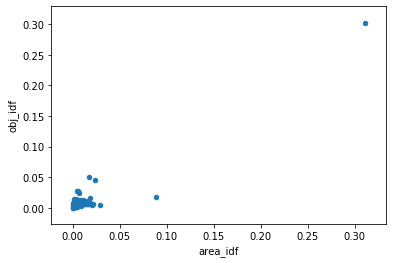

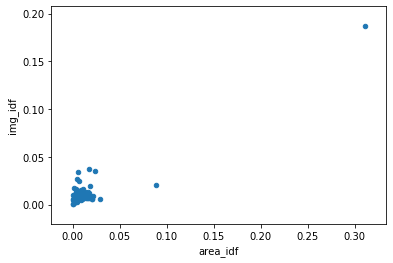

In [60]:

test2=idf
fig1=test2.plot(x='area_idf',y='obj_idf',kind='scatter').get_figure()
fig1.savefig('corr_without_person_obj.png')
fig2=test2.plot(x='area_idf',y='img_idf',kind='scatter').get_figure()
fig2.savefig('corr_without_person_img.png')
test2.corr()
idf.to_csv('idf.csv')

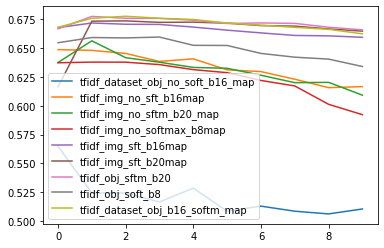

In [41]:
import os
import pandas as pd
import glob
import sys

df = pd.DataFrame()
files = glob.glob("../map/*.csv")
for file in files:
    map_csv=pd.read_csv(file)
    dat1 = pd.DataFrame({file.split('/')[2].split('.')[0]: map_csv['Value']})
    df=pd.concat([df,dat1],axis=1)
#     df.drop(columns=[""])
    df=df.dropna()

df.to_csv('comparative_map.csv')
df.plot()


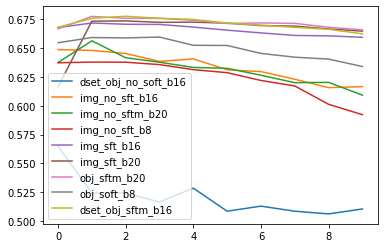

In [52]:
df=pd.read_csv('comparative_map.csv')
df=df.drop(columns=["index"])
fig=df.plot().get_figure()
fig.savefig('comparative_map.png')